# Exercise 7: Beamforming

In [1]:
from typing import Tuple

import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window, lfilter
from scipy.linalg import solve_toeplitz
from IPython.display import Audio
import math


%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 4)

In [2]:
# "Import" functions from previous exercises

import requests

gist = requests.get(
    "https://gist.githubusercontent.com/iibrahimli/3c50f73020c78aeee1de68ae5a0ba5e7/raw/import_funcs.py"
).text
print("Downloaded import_funcs.py")
exec(gist)

import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "plot_signal",
        "my_windowing",
        "acf",
        "estimate_fundamental_frequency",
    ],
)
import_function_from_ipynb(
    "exercise2.ipynb",
    [
        "compute_stft",
    ]
)
import_function_from_ipynb(
    "exercise3.ipynb",
    [
        "estimate_filter",
        "plot_dft",
    ]
)

Downloaded import_funcs.py
Found exercise1.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise1/exercise1.ipynb
Executed function plot_signal
Executed function my_windowing
Executed function acf
Executed function estimate_fundamental_frequency
Successfully imported functions: ['plot_signal', 'my_windowing', 'acf', 'estimate_fundamental_frequency']
Found exercise2.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise2/exercise2.ipynb
Executed function compute_stft
Successfully imported functions: ['compute_stft']
Found exercise3.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise3/exercise3.ipynb
Executed function estimate_filter
Executed function plot_dft
Successfully imported functions: ['estimate_filter', 'plot_dft']


## 2 Delay-and-Sum Beamformer

### Load signals

In [3]:
x_sensor, fs = librosa.core.load("AudioFiles/noisySensor.wav", sr=None, mono=False)
print(f"Samples: {x_sensor.shape[1]}, channels: {x_sensor.shape[0]}, sampling frequency: {fs} Hz")
n_channels = x_sensor.shape[0]
x_sensor.shape

Samples: 109466, channels: 4, sampling frequency: 16000 Hz


(4, 109466)

### Apply STFT

In [4]:
frame_length = 128 # ms
frame_shift = 32
sqrt_hann = 0.5 * np.sqrt(get_window("hann", frame_length * fs // 1000))

In [5]:
# apply stft to all channels of the signal
m_stft = []
for c in range(n_channels):
    m_stft_channel, v_freq, v_time = compute_stft(
        x_sensor[c],
        fs,
        frame_length,
        frame_shift,
        sqrt_hann,
    )
    m_stft.append(m_stft_channel)
m_stft = np.array(m_stft)
print("m_stft.shape:", m_stft.shape, "v_freq:", v_freq.shape, "v_time:", v_time.shape)

Output matches np.fft.rfft: True
Output matches np.fft.rfft: True
Output matches np.fft.rfft: True
Output matches np.fft.rfft: True
m_stft.shape: (4, 210, 1025) v_freq: (210,) v_time: (210,)


### Compute steering vectors

In [6]:
speed_of_sound = 343 # m/s
theta = np.pi / 4 # rad
d = 0.05 # m
n_freq_bins_total = len(v_freq) * 2 # number of total frequency bins 

# compute delay for each channel, shape: (n_channels,)
delays = np.arange(n_channels) * d / speed_of_sound * np.cos(theta)

# compute the steering vectors, shape: (n_freq_bins, n_channels)
steering_v = np.exp((-2j * np.pi * np.arange(len(v_freq)).reshape(-1, 1)) / n_freq_bins_total * delays.reshape(1, -1))
steering_v.shape

(210, 4)

### Align and add up signals

In [7]:
m_stft_hat = np.zeros_like(m_stft)

# alphas: (n_freq_bins, n_channels) or (k, n)
# m_stft: (n_channels, n_freq_bins, n_frames) or (n, k, l)
m_stft_hat = np.einsum("kn,nkl->kl", steering_v.conj(), m_stft) / n_channels

# m_stft_hat: (n_freq_bins, n_frames) or (k, l)
m_stft_hat.shape

(210, 1025)

### Plot magnitude spectrograms

In [8]:
def plot_log_spectrogram(
    m_stft: np.ndarray,
    v_freq: np.ndarray,
    v_time: np.ndarray,
    sampling_rate: int,
    fig: plt.Figure = None,
    ax: plt.Axes = None,
) -> None:
    """Plot the log spectrogram of a signal."""

    magnitude = 10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15)))
    im = ax.imshow(
        magnitude,
        cmap="viridis",
        origin="lower",
        extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
        aspect="auto",
    )

    plt.colorbar(im, orientation="vertical", ax=ax, pad=0.01)
    im.colorbar.set_label("Magnitude [dB]", rotation=270, labelpad=15)

    ax.set_title(f"Spectrogram \n (frame length: {frame_length} ms, frame shift: {frame_shift} ms)")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Frequency [Hz]")
    # ax.set_yscale("log")

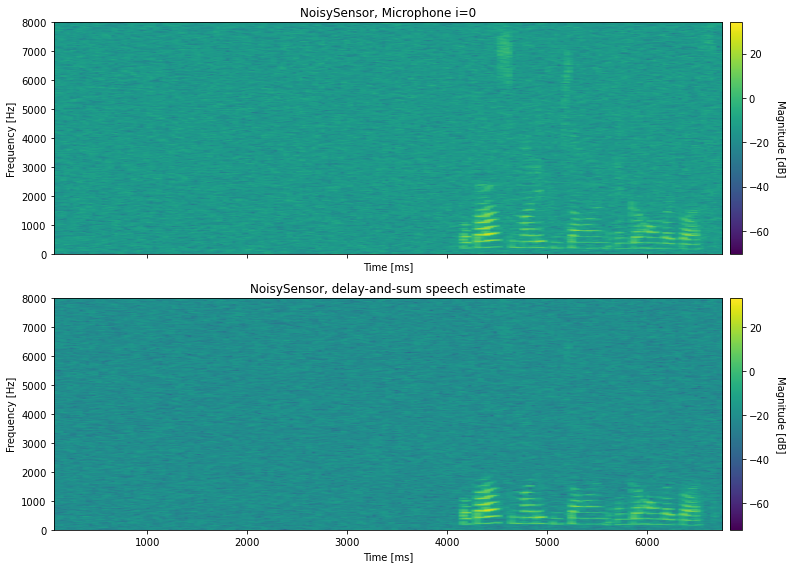

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_log_spectrogram(m_stft[0], v_freq, v_time, fs, fig=fig, ax=axs[0])
axs[0].set_title("NoisySensor, Microphone i=0")

plot_log_spectrogram(m_stft_hat, v_freq, v_time, fs, fig=fig, ax=axs[1])
axs[1].set_title("NoisySensor, delay-and-sum speech estimate")

fig.tight_layout()

### Reconstruct the signal

In [10]:
from code_exercise2 import compute_istft

In [11]:
print("Original from microphone i=0")
Audio(x_sensor[0], rate=fs)

Original from microphone i=0


In [12]:
x_reconstructed = compute_istft(m_stft_hat, fs, frame_shift, sqrt_hann)

print("Reconstructed speech with delay-and-sum beamforming")
Audio(x_reconstructed, rate=fs)

Reconstructed speech


## 3 Minimum Variance Distortionless Response (MVDR) Beamformer

In [13]:
# compute noise covariance matrix as the avg of noise-only frames (first 1 second)
n_noise_frames = int(1 * fs / frame_shift)
print(f"Computing noise covariance matrix from {n_noise_frames} frames")

# shape: (n, k, l)
noise_frames = m_stft[:, :, :n_noise_frames]

# compute noise covariance matrix for each frequency bin, shape: (k, n, n)
noise_cov_matrix = []
for k in range(len(v_freq)):
    noise_cov_matrix.append(noise_frames[:, k] @ noise_frames[:, k].conj().T / n_noise_frames)
noise_cov_matrix = np.array(noise_cov_matrix)
noise_cov_matrix.shape

Computing noise covariance matrix from 500 frames


(210, 4, 4)

### Compute MVDR filter

In [30]:
h_mvdr = []
for k in range(len(v_freq)):
    numerator = np.linalg.solve(noise_cov_matrix[k], steering_v[k])
    denominator = steering_v[k].conj() @ numerator
    h_mvdr.append(numerator / denominator)
h_mvdr = np.array(h_mvdr)
h_mvdr.shape

(210, 4)

### Obtain speech estimate

In [48]:
m_stft_mvdr = np.einsum("kn,nkl->kl", h_mvdr.conj(), m_stft)
m_stft_mvdr.shape

(210, 1025)

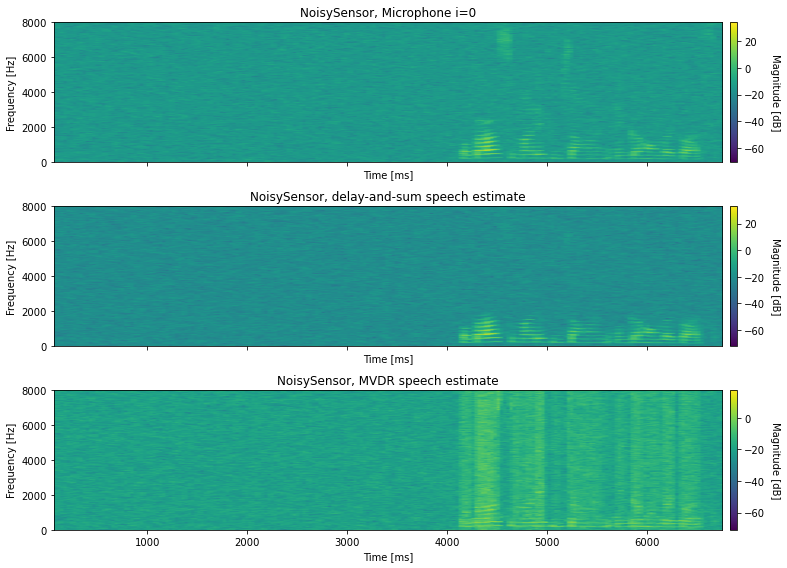

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

plot_log_spectrogram(m_stft[0], v_freq, v_time, fs, fig=fig, ax=axs[0])
axs[0].set_title("NoisySensor, Microphone i=0")

plot_log_spectrogram(m_stft_hat, v_freq, v_time, fs, fig=fig, ax=axs[1])
axs[1].set_title("NoisySensor, delay-and-sum speech estimate")

plot_log_spectrogram(m_stft_mvdr, v_freq, v_time, fs, fig=fig, ax=axs[2])
axs[2].set_title("NoisySensor, MVDR speech estimate")

fig.tight_layout()

### Reconstruct the signal

In [54]:
print("Original from microphone i=0")
Audio(x_sensor[0], rate=fs)

Original from microphone i=0


In [55]:
x_reconstructed = compute_istft(m_stft_hat, fs, frame_shift, sqrt_hann)

print("Reconstructed speech with delay-and-sum beamforming")
Audio(x_reconstructed, rate=fs)

Reconstructed speech with delay-and-sum beamforming


In [56]:
x_reconstructed = compute_istft(m_stft_mvdr, fs, frame_shift, sqrt_hann)

print("Reconstructed speech with MVDR beamforming")
Audio(x_reconstructed, rate=fs)

Reconstructed speech with MVDR beamforming
